In [1]:
#| echo: False
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph, pinta_tikz, plot_cargas

In [2]:
#| echo: false
#| output: false
%%capture
%mkdir -p ~/temp
%cd ~/temp

# Enunciado
## Cálculo de la duración de un proyecto usando el Método de Montecarlo

Considere el proyecto cuya información se adjunta.

In [3]:
#| echo: False
pregunta_1 = f"1. Dibuje el grafo PERT del proyecto.  "
pregunta_2 = f"2. Determine las ecuaciones de los tiempos tempranos de cada nodo.  "
pregunta_3 = f"3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.  "
pregunta_4 = f"4. Determina la duración media y la desviación típica de la duración del proyecto.  "
pregunta_5 = f"5. Determine la duración para una probabilidad de completar antes el proyecto del 98%.  "

In [4]:
#| echo: False
display(Markdown(pregunta_1))
display(Markdown(pregunta_2))
display(Markdown(pregunta_3))
display(Markdown(pregunta_4))
display(Markdown(pregunta_5))

1. Dibuje el grafo PERT del proyecto.  

2. Determine las ecuaciones de los tiempos tempranos de cada nodo.  

3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.  

4. Determina la duración media y la desviación típica de la duración del proyecto.  

5. Determine la duración para una probabilidad de completar antes el proyecto del 98%.  

In [5]:
#| tbl-cap: "Cuadro de datos del enunciado del ejercicio"
#| label: tbl-datosEnunciado
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import numpy as np
import matplotlib as plt
%matplotlib inline

datos_enunciado = pd.DataFrame([
#  actividad, predecesora, duracion media, desviación típica
     ('A',    '---  ', 10, 1.5 ),
     ('B',    '---  ',  5, 0.4 ),
     ('C',    'A    ',  6, 0.8 ),
     ('D',    'A    ',  2, 0.7 ),
     ('E',    'B,C,D',  7, 1.8 ),
     ('F',    'B,D  ',  8, 0.8 ),
     ('G',    'E,F  ',  4, 1.4 ),
     ('H',    'B    ',  7, 1.6 ),
] ,columns=['activity', 'predecessor', 'mean', 'stdev']).set_index('activity')

datos_enunciado

,predecessor,mean,stdev
activity,,,
A,---,10,1.5
B,---,5,0.4
C,A,6,0.8
D,A,2,0.7
E,"B,C,D",7,1.8
F,"B,D",8,0.8
G,"E,F",4,1.4
H,B,7,1.6


# Solución
## Apartado 1

In [6]:
#| echo: False
display(Markdown(pregunta_1))

1. Dibuje el grafo PERT del proyecto.  

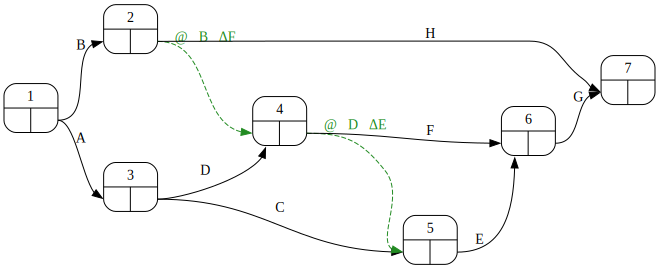

In [7]:
#| fig-cap: "Grafo Pert con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
datos_proyecto =  datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
proyecto = prelaciones.create_project()
proyecto.pert()

## Apartado 2

In [8]:
#| echo: False
display(Markdown(pregunta_2))

2. Determine las ecuaciones de los tiempos tempranos de cada nodo.  

$$\begin{aligned}
t_1 &= 0\\
t_2 &= t_1 + B\\
t_3 &= t_1 + A\\
t_4 &= \max \left[ t_2 + d_{@∇B⤑ΔF} \; , \;  t_3 + D \right]           \\
t_5 &= \max \left[ t_3 + C          \; , \;   t_4 + d_{@∇D⤑ΔE} \right] \\
t_6 &= \max \left[ t_5 + E          \; , \;   t_4 + F \right]          \\
t_7 &= \max \left[ t_6+ G           \; , \;   t_2 + H \right]          \\
\end{aligned}
$$

## Apartado 3

In [9]:
#| echo: False
display(Markdown(pregunta_3))

3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.  

### Generación aleatoria de las duraciones de las actividades

In [10]:
number_of_samples = 1000

In [11]:
activity_names = datos_proyecto.index
duration = pd.DataFrame([np.random.normal(size = number_of_samples,
                                          loc  = datos_proyecto.loc[task, 'mean',],
                                          scale= datos_proyecto.loc[task, 'stdev'])
                         for task in activity_names
                        ],
                        index=activity_names).T

In [12]:
duration.head()

activity,A,B,C,D,E,F,G,H
0,9.081096,4.925977,6.808765,2.199166,6.661483,6.813423,4.142801,8.528210
1,8.819421,4.879878,6.356081,3.055740,8.104175,8.680826,5.676649,11.197426
2,10.544757,5.055635,4.541225,1.223438,9.122850,8.197525,1.908224,4.608843
3,11.836664,3.712533,7.231890,1.955516,4.592469,8.813498,4.792855,9.433209
4,8.049775,4.557992,5.899066,2.552336,10.265756,7.260778,4.295060,6.688963


### Cálculo de los tiempos tempranos

In [13]:
def row_max(A,B):
    return pd.concat([A,B], axis=1).max(axis=1)

In [14]:
t_early = duration.copy()
t_early.eval("""t_1 = 0
                t_2 = t_1 + B

                t_3 = t_1 + A

                input_D = t_3 + D
                input_f_B_F = t_2 + 0
                t_4 = @row_max(input_D, input_f_B_F)

                input_C = t_3 + C
                input_f_D_E = t_4 + 0
                t_5 = @row_max(input_C, input_f_D_E)

                input_E = t_5 + E
                input_F = t_4 + F
                t_6 = @row_max(input_E, input_F)

                input_G = t_6 + G
                input_H = t_2 + H
                t_7 = @row_max(input_G, input_H)
                """, inplace=True)

In [15]:
tiempos_nodos = ['t_'+ str(num) for num in range(1, 8)]
t_early.loc[0:10, : ]

activity,A,B,C,D,E,F,G,H,t_1,t_2,t_3,input_D,input_f_B_F,t_4,input_C,input_f_D_E,t_5,input_E,input_F,t_6,input_G,input_H,t_7
0,9.081096,4.925977,6.808765,2.199166,6.661483,6.813423,4.142801,8.528210,0,4.925977,9.081096,11.280262,4.925977,11.280262,15.889861,11.280262,15.889861,22.551344,18.093685,22.551344,26.694145,13.454186,26.694145
1,8.819421,4.879878,6.356081,3.055740,8.104175,8.680826,5.676649,11.197426,0,4.879878,8.819421,11.875161,4.879878,11.875161,15.175502,11.875161,15.175502,23.279677,20.555987,23.279677,28.956325,16.077304,28.956325
2,10.544757,5.055635,4.541225,1.223438,9.122850,8.197525,1.908224,4.608843,0,5.055635,10.544757,11.768194,5.055635,11.768194,15.085982,11.768194,15.085982,24.208832,19.965719,24.208832,26.117056,9.664478,26.117056
3,11.836664,3.712533,7.231890,1.955516,4.592469,8.813498,4.792855,9.433209,0,3.712533,11.836664,13.792180,3.712533,13.792180,19.068554,13.792180,19.068554,23.661023,22.605678,23.661023,28.453879,13.145743,28.453879
4,8.049775,4.557992,5.899066,2.552336,10.265756,7.260778,4.295060,6.688963,0,4.557992,8.049775,10.602111,4.557992,10.602111,13.948841,10.602111,13.948841,24.214597,17.862889,24.214597,28.509657,11.246955,28.509657
5,9.570554,5.247354,4.908092,1.482887,6.825398,9.000541,3.773382,6.128493,0,5.247354,9.570554,11.053441,5.247354,11.053441,14.478646,11.053441,14.478646,21.304044,20.053982,21.304044,25.077426,11.375847,25.077426
6,11.286058,5.387568,6.501076,2.881178,5.058256,7.306474,3.129270,3.955114,0,5.387568,11.286058,14.167236,5.387568,14.167236,17.787134,14.167236,17.787134,22.845390,21.473710,22.845390,25.974660,9.342682,25.974660
7,10.554542,5.529661,6.231901,2.158020,5.774344,6.466144,4.808225,9.032276,0,5.529661,10.554542,12.712562,5.529661,12.712562,16.786442,12.712562,16.786442,22.560787,19.178705,22.560787,27.369011,14.561937,27.369011
8,9.568515,4.308716,5.749297,3.675965,5.283459,7.059711,3.219016,8.296559,0,4.308716,9.568515,13.244480,4.308716,13.244480,15.317812,13.244480,15.317812,20.601271,20.304190,20.601271,23.820287,12.605275,23.820287
9,7.168883,4.674926,5.304946,1.650841,7.254230,7.189059,4.333333,4.986467,0,4.674926,7.168883,8.819724,4.674926,8.819724,12.473829,8.819724,12.473829,19.728059,16.008783,19.728059,24.061391,9.661393,24.061391


## Apartado 4

In [16]:
#| echo: False
display(Markdown(pregunta_4))

4. Determina la duración media y la desviación típica de la duración del proyecto.  

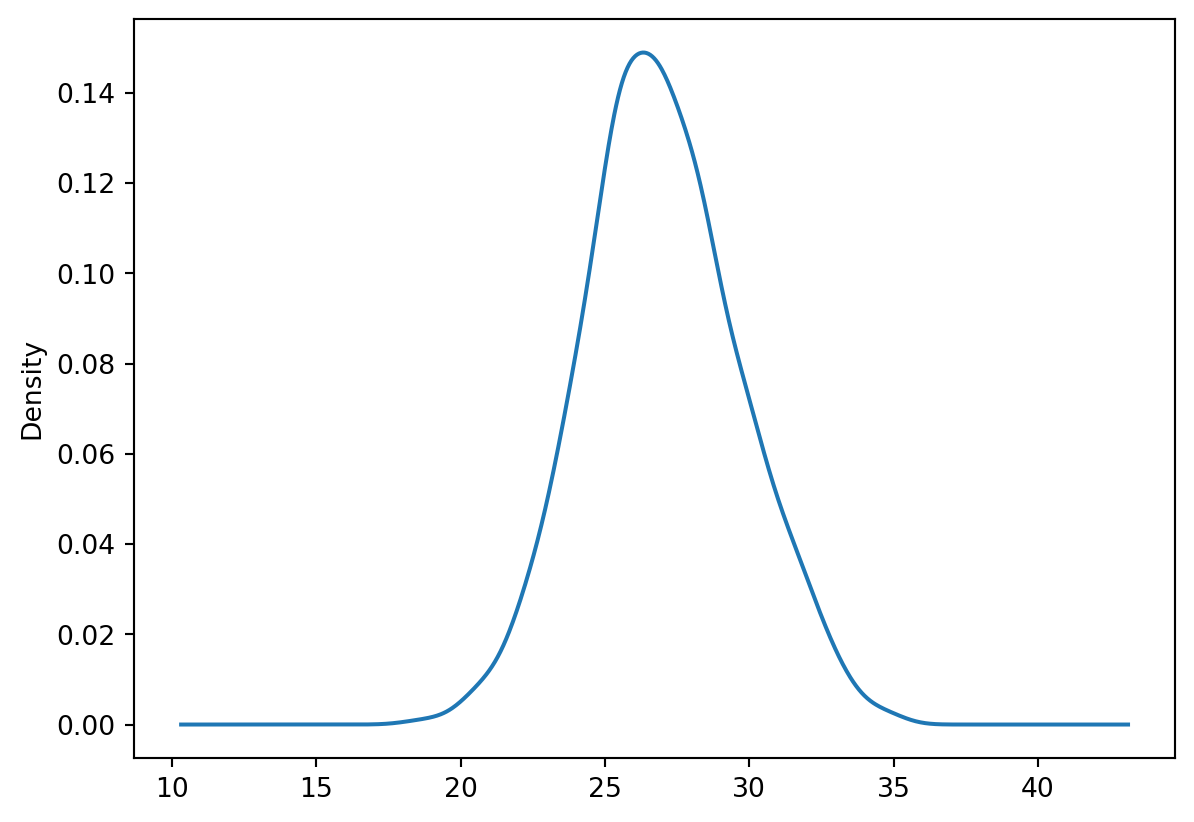

In [17]:
t_early['t_7'].plot(kind='density');

In [18]:
t_early['t_7'].describe()

count    1000.000000
mean       26.965845
std         2.667210
min        18.514911
25%        25.218264
50%        26.804252
75%        28.683346
max        34.917397
Name: t_7, dtype: float64

In [19]:
f"La duración media del proyecto es:{t_early['t_7'].mean()}, la desviación típica de la duración del proyecto es:{t_early['t_7'].std()}"

'La duración media del proyecto es:26.96584481747838, la desviación típica de la duración del proyecto es:2.6672104114475466'

La desviación típica de la duración del proyecto es:

## Apartado 5

In [20]:
#| echo: False
display(Markdown(pregunta_5))

5. Determine la duración para una probabilidad de completar antes el proyecto del 98%.  

In [21]:
resultado_1 = round(t_early['t_7'].sort_values(ascending=True).iloc[int(0.98*number_of_samples)],1)

In [22]:
Markdown(f"Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 98% de las muestras. De esta manera obtenemos un resultado igual a {resultado_1} periodos")

Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 98% de las muestras. De esta manera obtenemos un resultado igual a 32.7 periodos

In [23]:
resultado_2 = round(t_early['t_7'].quantile(q=0.98, interpolation='higher'), 1)

In [24]:
Markdown(f"O bien, utilizando la función `quantile`, obteniendo igualmente un valor de {resultado_2} periodos.")

O bien, utilizando la función `quantile`, obteniendo igualmente un valor de 32.7 periodos.